# Aviation Accidents Analysis

You are part of a consulting firm that is tasked to do an analysis of commercial and passenger jet airline safety. The client (an airline/airplane insurer) is interested in knowing what types of aircraft (makes/models) exhibit low rates of total destruction and low likelihood of fatal or serious passenger injuries in the event of an accident. They are also interested in any general variables/conditions that might be at play. Your analysis will be based off of aviation accident data accumulated from the years 1948-2023. 

Our client is only interested in airplane makes/models that are professional builds and could potentially still be active. Assume a max lifetime of 40 years for a make/model retirement and make sure to filter your data accordingly (i.e. from 1983 onwards). They would also like separate recommendations for small aircraft vs. larger passenger models. **In addition, make sure that claims that you make are statistically robust and that you have enough samples when making comparisons between groups.**


In this summative assessment you will demonstrate your ability to:
- **Use Pandas to load, inspect, and clean the dataset appropriately.**
- **Transform relevant columns to create measures that address the problem at hand.**
- conduct EDA: visualization and statistical measures to systematically understand the structure of the data
- recommend a set of airplanes and makes conforming to the client's request and identify at least *two* factors contributing to airplane safety. You must provide supporting evidence (visuals, summary statistics, tables) for each claim you make.

### Make relevant library imports

In [921]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

## Data Loading and Inspection

### Load in data from the relevant directory and inspect the dataframe.
- inspect NaNs, datatypes, and summary statistics

In [922]:
# Load the data with latin-1 encoding to handle special characters
df = pd.read_csv('data/AviationData.csv', encoding='latin-1')
print(df.info())
print(df.describe())
print(df.isnull().sum())


/var/folders/fm/0br20h5n0_59w9nppqd33d8h0000gn/T/ipykernel_68850/538347047.py:2: DtypeWarning: Columns (6,7,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/AviationData.csv', encoding='latin-1')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88889 entries, 0 to 88888
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                88889 non-null  object 
 1   Investigation.Type      88889 non-null  object 
 2   Accident.Number         88889 non-null  object 
 3   Event.Date              88889 non-null  object 
 4   Location                88837 non-null  object 
 5   Country                 88663 non-null  object 
 6   Latitude                34382 non-null  object 
 7   Longitude               34373 non-null  object 
 8   Airport.Code            50132 non-null  object 
 9   Airport.Name            52704 non-null  object 
 10  Injury.Severity         87889 non-null  object 
 11  Aircraft.damage         85695 non-null  object 
 12  Aircraft.Category       32287 non-null  object 
 13  Registration.Number     87507 non-null  object 
 14  Make                    88826 non-null

## Data Cleaning

### Filtering aircrafts and events

We want to filter the dataset to include aircraft that the client is interested in an analysis of:
- inspect relevant columns
- figure out any reasonable imputations
- filter the dataset

In [923]:
#Select relevant columns and filter the data
columns = ['Country', 'Location', 'Injury.Severity', 'Aircraft.damage', 'Make', 'Model',
       'Amateur.Built', 'Total.Fatal.Injuries','Total.Serious.Injuries', 'Total.Minor.Injuries', 
       'Total.Uninjured', 'Publication.Date','Engine.Type','Weather.Condition',
       'Number.of.Engines','Purpose.of.flight','Broad.phase.of.flight']

#create subset of the data with the relevant columns
df_subset = df.loc[:, columns]
# Convert 'Publication.Date' to datetime and extract the year
df_subset['Publication.Date'] = pd.to_datetime(df_subset['Publication.Date'], dayfirst=True)
df_subset['Year'] = df_subset['Publication.Date'].dt.year.astype('Int16')

#filter the data to include only accidents from 1983 onwards and exclude amateur-built aircraft
df_subset = df_subset[
    (df_subset['Year'] >= 1983) & 
    (df_subset['Amateur.Built'] == 'No')
]


### Cleaning and constructing Key Measurables

Injuries and robustness to destruction are a key interest point for the client. Clean and impute relevant columns and then create derived fields that best quantifies what the client wishes to track. **Use commenting or markdown to explain any cleaning assumptions as well as any derived columns you create.**

Construct metric for fatal/serious injuries

Hint: Estimate the total number of passengers on each flight. The likelihood of serious / fatal injury can be estimated as a fraction from this.

In [924]:
#Select the injuries columns
injuries_categories = ['Total.Fatal.Injuries', 'Total.Serious.Injuries', 'Total.Minor.Injuries', 'Total.Uninjured']

#fill the NAN values in the injuries columns with 0, since a NAN value in these columns likely indicates that there were no injuries of that type
df_subset[injuries_categories] = df_subset[injuries_categories].fillna(0)


# create a total column to calculate the total number of people involved in each accident
df_subset['Total Passengers'] = df_subset[injuries_categories].sum(axis=1)

# i will take the flights with more than 0 passengers, since we are interested in analyzing the injuries data and identifying patterns and trends in accidents that involved people
df_subset = df_subset[df_subset['Total Passengers'] > 0]


#I will generate a boxplot to visualize the distribution of the injuries data and identify outliers
#fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
#for ax, col in zip(axes.flat, injuries_categories + ['Total Passengers']):
#    df_subset[col].plot.hist(
#        ax=ax,
#        bins=30,
#        color='steelblue',
#        edgecolor='white',
#        log=True          # ← very useful because most accidents have 0–few injuries
#    )
#    ax.set_title(col.replace('.', ' '))
#    ax.set_xlabel("Number of people")
#    ax.set_ylabel("Number of accidents (log scale)")

#plt.tight_layout()
#plt.show()

# Calculate the rate of serious and fatal injuries per total passengers for each accident

df_subset['Serious_Fatal_Rate'] = (df_subset['Total.Fatal.Injuries'] + df_subset['Total.Serious.Injuries'] ) / df_subset['Total Passengers']

print(df_subset.head())


         Country        Location Injury.Severity Aircraft.damage  \
1  United States  BRIDGEPORT, CA        Fatal(4)       Destroyed   
2  United States   Saltville, VA        Fatal(3)       Destroyed   
3  United States      EUREKA, CA        Fatal(2)       Destroyed   
5  United States      BOSTON, MA       Non-Fatal     Substantial   
6  United States      COTTON, MN        Fatal(4)       Destroyed   

                Make     Model Amateur.Built  Total.Fatal.Injuries  \
1              Piper  PA24-180            No                   4.0   
2             Cessna      172M            No                   3.0   
3           Rockwell       112            No                   2.0   
5  Mcdonnell Douglas       DC9            No                   0.0   
6             Cessna       180            No                   4.0   

   Total.Serious.Injuries  Total.Minor.Injuries  Total.Uninjured  \
1                     0.0                   0.0              0.0   
2                     0.0         

**Aircraft.Damage**
- identify and execute any cleaning tasks
- construct a derived column tracking whether an aircraft was destroyed or not.

Aircraft.damage
Substantial    49281
Destroyed      13043
NaN             2167
Minor           1978
Unknown           49
Name: count, dtype: int64


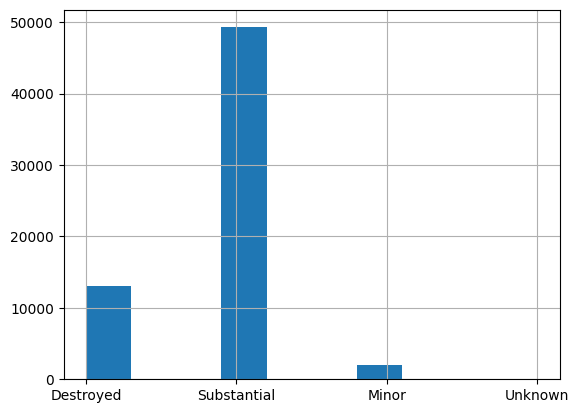

In [925]:
#i get the type of damage to the aircraft
print(df_subset['Aircraft.damage'].value_counts(dropna=False))

#Since the 'Aircraft.damage' column contains categorical data, I will create a histogram to visualize the distribution of the different types of damage and identify any patterns or trends in the data.
df_subset['Aircraft.damage'].hist()

#Since the mayority of the accidents resulted in 'Substantial' damage, the Unknown data will be treated as Not Destroyed, since it is more likely that the damage  will be substantial.
df_subset['is_destroyed'] = df_subset['Aircraft.damage'] == 'Destroyed'


### Investigate the *Make* column
- Identify cleaning tasks here
- List cleaning tasks clearly in markdown
- Execute the cleaning tasks
- For your analysis, keep Makes with a reasonable number (you can put the threshold at 50 though lower could work as well)

In [926]:
#First I identify the null numbers
df_subset['Make'].isnull().sum()
#print(df_subset['Make'].value_counts())

#Since They are only 23 they will be remove
df_subset = df_subset.dropna(subset=['Make'])
df_subset['Make'].isnull().sum()

#Then it will be removed any space and lowercase
def clean_make_full(name):
    if pd.isnull(name):
        return name
    # Lowercase and strip leading/trailing spaces
    name = name.strip().lower()
    # Remove all punctuation: . , : ; 
    name = re.sub(r'[\.,:;]+', '', name)
    # Remove common company words
    name = re.sub(r'\b(aircraft|inc|llc|co|corp|corporation|leasing|ltd)\b', '', name)
    # Remove extra spaces
    name = re.sub(r'\s+', ' ', name)
    return name.strip()

df_subset['Make'] = df_subset['Make'].apply(clean_make_full)


#Given some of them are repeated I will be replaced the following ones
make_mapping = {
    'robinson helicopter': 'robinson',
    'robinson helicopter company': 'robinson',
    'grumman american': 'grumman',
    'grumman american avn': 'grumman',
    'grumman acft eng cor-schweizer': 'grumman',
    'airbus industrie': 'airbus',
    'cirrus design': 'cirrus',
    'dehavilland': 'de havilland',
    'rockwell international': 'rockwell',
    'diamond ind': 'diamond',
    'gates learjet': 'learjet',
    'douglas': 'mcdonnell douglas',
    'american': 'american champion',
    'champion': 'american champion',
    'grumman-schweizer': 'schweizer',
    'ercoupe (eng & research )': 'ercoupe',
    'gulfstream american': 'gulfstream',
    'raytheon company': 'raytheon',
    'christen industries': 'christen',
}
df_subset['Make'] = df_subset['Make'].replace(make_mapping)

# Count the occurrences
make_counts = df_subset['Make'].value_counts(dropna=False)


valid_makes = make_counts[make_counts >= 50].index

df_subset = df_subset[df_subset['Make'].isin(valid_makes)]



### Inspect Model column
- Get rid of any NaNs.
- Inspect the column and counts for each model/make. Are model labels unique to each make?
- If not, create a derived column that is a unique identifier for a given plane type.

In [927]:
#First I identify the null numbers
df_subset['Model'].isnull().sum()
#print(df_subset['Model'].value_counts())

#Since They are only 14 they will be remove
df_subset = df_subset.dropna(subset=['Model'])
df_subset['Model'].isnull().sum()

# Counts per model
model_counts = df_subset['Model'].value_counts(dropna=False)
print(model_counts.head(20))

# Check if models are shared across Makes
model_make_counts = df_subset.groupby(['Make', 'Model']).size().reset_index(name='count')
print(model_make_counts.head(20))

# see if any Model appears under more than one Make
duplicate_models = df_subset.groupby('Model')['Make'].nunique()
shared_models = duplicate_models[duplicate_models > 1]
print(shared_models)

# Create unique plane type column
df_subset['Plane Type'] = df_subset['Make'] + ' ' + df_subset['Model']

# Optional: strip extra spaces and lowercase
df_subset['Plane Type'] = df_subset['Plane Type'].str.strip().str.lower()

# Check
df_subset[['Make', 'Model', 'Plane Type']].head(10)

Model
152          1812
172          1486
172N          985
PA-28-140     745
172M          678
150           660
172P          579
182           555
180           534
PA-18-150     489
PA-28-161     479
PA-28-180     476
PA-18         474
150M          460
206B          423
PA-28-181     418
A36           393
150L          364
172S          361
G-164A        348
Name: count, dtype: int64
              Make    Model  count
0   aero commander      100     33
1   aero commander  100 180      1
2   aero commander  100-180     15
3   aero commander      112     16
4   aero commander     1121      1
5   aero commander     112A      2
6   aero commander    112TC      1
7   aero commander    114-B      1
8   aero commander     114B      1
9   aero commander      200      1
10  aero commander     200D     12
11  aero commander      500     13
12  aero commander  500 - B      1
13  aero commander    500 B      2
14  aero commander    500 S      4
15  aero commander  500-698      1
16  aero comm

,Make,Model,Plane Type
1,piper,PA24-180,piper pa24-180
2,cessna,172M,cessna 172m
3,rockwell,112,rockwell 112
5,mcdonnell douglas,DC9,mcdonnell douglas dc9
6,cessna,180,cessna 180
12,bellanca,17-30A,bellanca 17-30a
13,cessna,R172K,cessna r172k
14,navion,A,navion a
15,beech,19,beech 19
16,enstrom,280C,enstrom 280c


### Cleaning other columns
- there are other columns containing data that might be related to the outcome of an accident. We list a few here:
- Engine.Type
- Weather.Condition
- Number.of.Engines
- Purpose.of.flight
- Broad.phase.of.flight

Inspect and identify potential cleaning tasks in each of the above columns. Execute those cleaning tasks. 

**Note**: You do not necessarily need to impute or drop NaNs here.

In [928]:
#df_subset.info()

#after view the info

#Check the values of EngineType
#print(df_subset['Engine.Type'].value_counts(dropna=False))

#Given the following values Reciprocating,Turbo Prop, Turbo Shaft, Turbo Fan, Unknown, Turbo Jet, Geared Turbofan,
#LR, UNK, NONE
#Map the UNK, NONE, UNKNOWN NaN AS unknown
#Since only we have 1 record for LR: unknown and 1 'geared turbofan': 'turbo fan'

engine_mapping = {
    'unknown': 'unknown',
    'unk': 'unknown',
    'none': 'unknown',
    'lr':'unknown',
    'geared turbofan': 'turbo fan'
}

# Clean Engine.Type
df_subset['Engine.Type'] = df_subset['Engine.Type'].str.strip().str.lower()
df_subset['Engine.Type'] = df_subset['Engine.Type'].replace(engine_mapping)
df_subset['Engine.Type'] = df_subset['Engine.Type'].fillna('unknown')

#print(df_subset['Engine.Type'].value_counts(dropna= False))


#Check the values of EngineType
#print(df_subset['Weather.Condition'].value_counts(dropna= False))

# Standardize Weather.Condition
df_subset['Weather.Condition'] = df_subset['Weather.Condition'].str.strip().str.lower()

# Map abbreviations / unknowns about the NaN even the majority are VMC nan will be treated as unknown
weather_mapping = {
    'vmc': 'visual',
    'imc': 'instrument',
    'unk': 'unknown'
}

df_subset['Weather.Condition'] = df_subset['Weather.Condition'].replace(weather_mapping)
df_subset['Weather.Condition'] = df_subset['Weather.Condition'].fillna('unknown')

# Check results
#print(df_subset['Weather.Condition'].value_counts(dropna=False))



# Standardize Number.of.Engines
#print(df_subset['Number.of.Engines'].value_counts(dropna=False))

#knowing that  "Reciprocating" engine is usually a 1, while a "Turbo Fan" is almost always 2 or more.
#will replace the nan using this approach
engine_mode_map = df_subset.groupby('Engine.Type')['Number.of.Engines'].agg(
    lambda x: x.mode().iloc[0] if not x.mode().empty else 1.0
)

# Use that map to fill the NaNs
df_subset['Number.of.Engines'] = df_subset['Number.of.Engines'].fillna(
    df_subset['Engine.Type'].map(engine_mode_map)
)

#print(df_subset['Number.of.Engines'].value_counts(dropna=False))



# Standardize Purpose of flight
#print(df_subset['Purpose.of.flight'].value_counts(dropna=False))

#Due to the given categories the mapping will be:

# 2. Define the Mapping
purpose_map = {
    # Consolidate Public Aircraft
    'public aircraft - federal': 'public aircraft',
    'public aircraft - state': 'public aircraft',
    'public aircraft - local': 'public aircraft',
    
    # Consolidate Air Race
    'air race show': 'air race/show',
    
    # Consolidate Codes & Missing into 'unknown'
    'nan': 'unknown',
    'pubs': 'public aircraft', # Usually Public Service
    'asho': 'air race/show',   # Usually Air Show
    'publ': 'public aircraft',
    
    # Group very rare specialized flights into 'other work use'
    'external load': 'other work use',
    'banner tow': 'other work use',
    'glider tow': 'other work use',
    'air drop': 'other work use',
    'firefighting': 'other work use'
}

#Clean the records
df_subset['Purpose.of.flight'] = df_subset['Purpose.of.flight'].astype(str).str.lower().str.strip()

# Apply the map
df_subset['Purpose.of.flight'] = df_subset['Purpose.of.flight'].replace(purpose_map)

#print(df_subset['Purpose.of.flight'].value_counts())




# Standardize Broad.phase of flight
print(df_subset['Broad.phase.of.flight'].value_counts(dropna=False))

#Due to the high number of missing this column will be removed

Broad.phase.of.flight
NaN            18830
Landing        10978
Takeoff         8237
Cruise          7061
Maneuvering     5240
Approach        4397
Taxi            1452
Climb           1413
Descent         1323
Go-around        974
Standing         702
Unknown          317
Other             62
Name: count, dtype: int64


### Column Removal
- inspect the dataframe and drop any columns that have too many NaNs

In [929]:
df_subset = df_subset.drop('Broad.phase.of.flight', axis=1)

### Save DataFrame to csv
- its generally useful to save data to file/server after its in a sufficiently cleaned or intermediate state
- the data can then be loaded directly in another notebook for further analysis
- this helps keep your notebooks and workflow readable, clean and modularized

In [930]:
df_subset.info()
df_subset.to_csv('cleaned_aviation_data.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 60986 entries, 1 to 88888
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Country                 60840 non-null  object        
 1   Location                60957 non-null  object        
 2   Injury.Severity         60986 non-null  object        
 3   Aircraft.damage         59107 non-null  object        
 4   Make                    60986 non-null  object        
 5   Model                   60986 non-null  object        
 6   Amateur.Built           60986 non-null  object        
 7   Total.Fatal.Injuries    60986 non-null  float64       
 8   Total.Serious.Injuries  60986 non-null  float64       
 9   Total.Minor.Injuries    60986 non-null  float64       
 10  Total.Uninjured         60986 non-null  float64       
 11  Publication.Date        60986 non-null  datetime64[ns]
 12  Engine.Type             60986 non-null  object     